# P2C

In [1]:
%cd ..

/Users/juansegundohevia/Documents/repos/ELEC542-TextGuidedRecolorization


In [2]:
import os 
import pickle as pkl

In [6]:
src_path = os.path.join('./data/hexcolor_vf/train_names.pkl')
with open(src_path, 'rb') as f:
    names = pkl.load(f)

print("Loading %s palette names..." % len(names))
print("Making text dictionary...")

Loading 9165 palette names...
Making text dictionary...


In [8]:
names[:10]

[['it', 'is', 'cold'],
 ['gloomy', 'blue'],
 ['ugly'],
 ['screaming', 'into', 'the', 'void'],
 ['green'],
 ['grape', 'to', 'strawberry'],
 ['fresh', 'squeezed', 'orange', 'juice'],
 ['depression', 'days'],
 ['shoot'],
 ['day', 'in', 'the', 'rainforest']]

In [9]:
with open('./data/hexcolor_vf/train_palettes_rgb.pkl', 'rb') as f:
    pals = pkl.load(f)

pals[:4]

[[(86, 131, 192),
  (151, 221, 209),
  (128, 109, 212),
  (160, 208, 218),
  (191, 167, 229)],
 [(57, 89, 118), (73, 112, 135), (27, 99, 135), (34, 77, 109), (28, 56, 77)],
 [(111, 46, 46), (62, 89, 163), (99, 78, 46), (81, 88, 23), (56, 50, 53)],
 [(134, 156, 165), (140, 118, 159), (90, 57, 114), (49, 17, 81), (43, 5, 41)]]

In [25]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_palette(palette: list, name:str = None):
    '''
    Take a list of 5 RGB colors defined as (R, G, B) in the range [0, 255]
    and plot them as a horizontal bar of squares.
    '''
    palette = np.array(palette) / 255.0
    plt.figure(figsize=(8, 2))
    plt.imshow([palette], aspect='auto')
    plt.axis('off')
    if name:
        plt.title(name)
    plt.show()

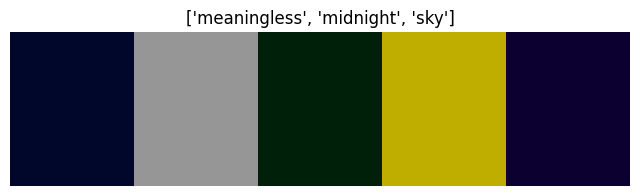

In [31]:
idx = np.random.randint(len(pals))  # get a random index
visualize_palette(pals[idx], names[idx])  # visualize first palette

# Palette to Color Dataset (P2C)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_palette(palette: list, name:str = None):
    '''
    Take a list of 5 RGB colors defined as (R, G, B) in the range [0, 255]
    and plot them as a horizontal bar of squares.
    '''
    palette = np.array(palette) / 255.0
    plt.figure(figsize=(8, 2))
    plt.imshow([palette], aspect='auto')
    plt.axis('off')
    if name:
        plt.title(name)
    plt.show()

In [4]:
%cd ..

/Users/juansegundohevia/Documents/repos/ConceptGuidedColorization


In [5]:
import numpy as np
import os 
import pickle as pkl
from skimage.color import rgb2lab

In [6]:
data_path_imgs = "data/bird256/test_palette/test_images_origin.txt"
data_path_palettes = "data/bird256/test_palette/test_palette_origin.txt"

In [7]:
with open(data_path_imgs, 'rb') as f:
    imgs = pkl.load(f)


In [9]:
imgs[0].shape

(3, 256, 256)

In [8]:
with open(data_path_palettes, 'rb') as f:
    pals = pkl.load(f)

In [98]:
del imgs

In [99]:
del pals

In [9]:
type(imgs)

list

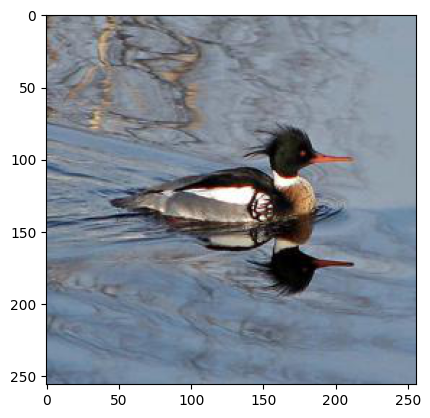

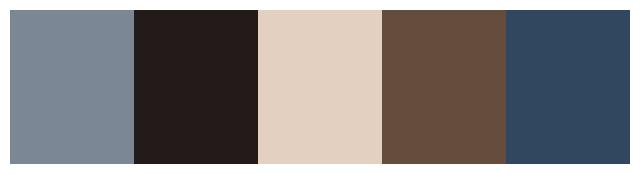

In [59]:
import matplotlib.pyplot as plt

IDX = np.random.randint(len(imgs))

plt.imshow(imgs[IDX].transpose(1, 2, 0) / 255)
_pal = pals[IDX].reshape(5, 3)
visualize_palette(_pal)
_pal = rgb2lab(np.asarray(pals[IDX]  / 256).reshape(5, 3))


In [11]:
import torch
def process_palette_ab(pal_data, batch_size):

    img_a_scale = (pal_data[:, :, 1:2] + 88) / 185
    img_b_scale = (pal_data[:, :, 2:3] + 127) / 212
    img_ab_scale = np.concatenate((img_a_scale,img_b_scale),axis=2)
    ab_for_global = torch.from_numpy(img_ab_scale).float()
    ab_for_global = ab_for_global.view(batch_size, 10).unsqueeze(2).unsqueeze(2)

    return ab_for_global

def process_palette_lab(pal_data, batch_size):

    img_l = pal_data[:, :, 0:1] / 100
    img_a_scale = (pal_data[:, :, 1:2] + 88) / 185
    img_b_scale = (pal_data[:, :, 2:3] + 127) / 212
    img_lab_scale = np.concatenate((img_l, img_a_scale, img_b_scale),axis=2)
    lab_for_global = torch.from_numpy(img_lab_scale).float()
    lab_for_global = lab_for_global.view(batch_size, 15).unsqueeze(2).unsqueeze(2)

    return lab_for_global

def process_data(image_data, batch_size, imsize):
    input = torch.zeros(batch_size, 1, imsize, imsize)
    labels = torch.zeros(batch_size, 2, imsize, imsize)
    images_np = image_data.numpy().transpose((0, 2, 3, 1))

    for k in range(batch_size):

        img_lab = rgb2lab(images_np[k], illuminant='D50')
        img_l = img_lab[:, :,0] / 100
        input[k] = torch.from_numpy(np.expand_dims(img_l, 0))

        img_a_scale = (img_lab[:, :, 1:2] + 88) / 185
        img_b_scale = (img_lab[:, :, 2:3] + 127) / 212

        img_ab_scale = np.concatenate((img_a_scale,img_b_scale),axis=2)
        labels[k] = torch.from_numpy(img_ab_scale.transpose((2, 0, 1)))

    return input, labels


def process_global_lab(input_lab, batch_size, always_give_global_hint):
    X_hist = input_lab

    if always_give_global_hint:
        B_hist = torch.ones(batch_size, 1, 1, 1)
    else:
        B_hist = torch.round(torch.rand(batch_size, 1, 1, 1))
        for l in range(batch_size):
            if B_hist[l].numpy() == 0:
                X_hist[l] = torch.rand((15, 1, 1))

    global_input = torch.cat([X_hist, B_hist], 1)
    return global_input

In [28]:
_pal.shape

(5, 3)

In [29]:
_pal = process_palette_lab(np.array([_pal]), 1)

In [30]:
_gh = process_global_lab(_pal, 1, True)

In [31]:
_gh.shape

torch.Size([1, 16, 1, 1])

In [60]:
def process_image(image_data, batch_size, imsize):
    input = torch.zeros(batch_size, 1, imsize, imsize)
    labels = torch.zeros(batch_size, 2, imsize, imsize)
    images_np = image_data.numpy().transpose((0, 2, 3, 1))

    for k in range(batch_size):
        img_lab = rgb2lab(images_np[k], illuminant='D50')
        img_l = img_lab[:, :, 0] / 100
        input[k] = torch.from_numpy(np.expand_dims(img_l, 0))

        img_a_scale = (img_lab[:, :, 1:2] + 88) / 185
        img_b_scale = (img_lab[:, :, 2:3] + 127) / 212

        img_ab_scale = np.concatenate((img_a_scale, img_b_scale), axis=2)
        labels[k] = torch.from_numpy(img_ab_scale.transpose((2, 0, 1)))
    return input, labels

In [61]:
import torch

inputs, labels = process_image(torch.Tensor([imgs[0]]), 1, 256) # labels size [2,2,256,256] , inputs size [2,1,256,256]

In [62]:
labels.size()

torch.Size([1, 2, 256, 256])

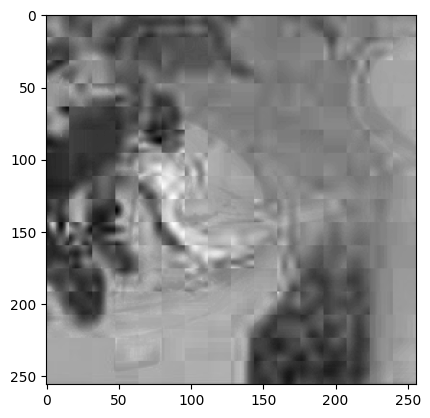

In [63]:
plt.imshow(labels.squeeze(0)[0].numpy(), cmap='gray')

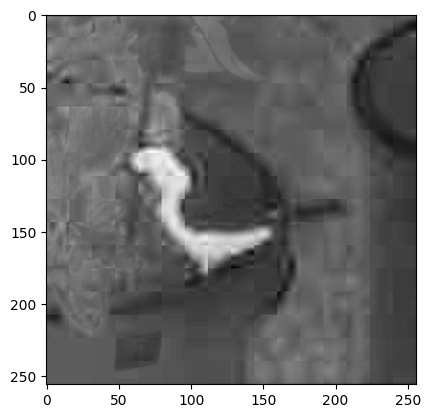

In [64]:
plt.imshow(labels.squeeze(0)[1].numpy(), cmap='gray')

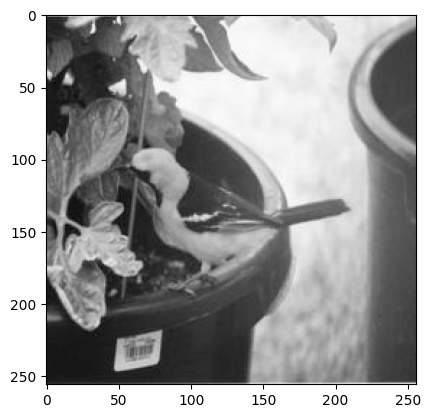

In [65]:
plt.imshow(inputs.squeeze(0)[0].numpy(), cmap='gray')

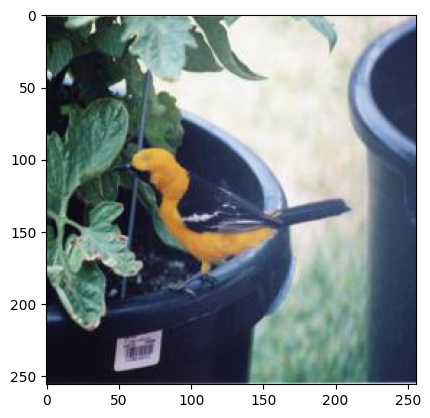

In [66]:
plt.imshow(imgs[0].transpose(1, 2, 0) / 255)

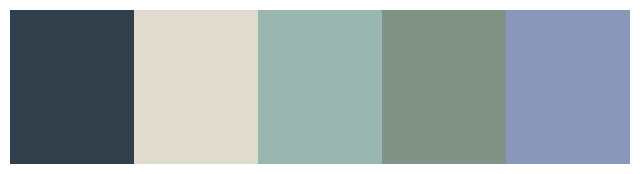

In [67]:
_ = np.asarray(pals[0]).reshape(5, 3)
visualize_palette(_)

In [46]:
from skimage.color import lab2rgb

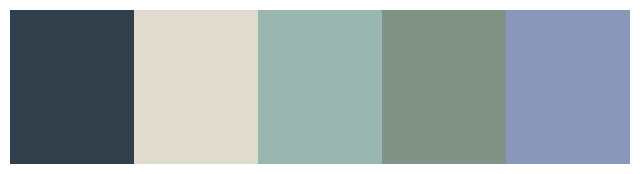

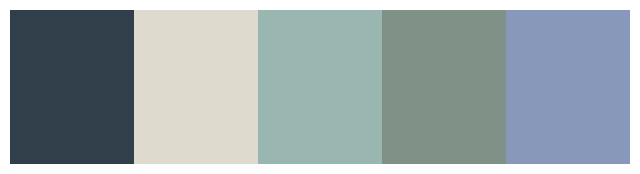

In [70]:
# visualize palette 0
# _pal = rgb2lab(np.asarray(pals[0]  / 256).reshape(5, 3))
# _pal = process_palette_lab(np.array([_pal]), 1)
# _gh = process_global_lab(_pal, 1, True)
_pal = pals[0].reshape(5, 3)
visualize_palette(_pal)
_pal = lab2rgb(rgb2lab(np.asarray(pals[0]  / 256).reshape(5, 3))) * 256
visualize_palette(_pal)

In [41]:
_pal

array([[ 25.689377  ,  -2.9283166 ,  -8.623624  ],
       [ 87.08775   ,  -0.8804798 ,   6.8517447 ],
       [ 71.82129   , -11.570215  ,   0.15541315],
       [ 58.736847  ,  -8.309067  ,   3.7593365 ],
       [ 62.550507  ,   2.3961961 , -19.322157  ]], dtype=float32)

# Lazy Loadings

In [72]:
train_img_path = './data/bird256/train_palette/train_images_origin.txt'
train_pal_path = './data/bird256/train_palette/train_palette_origin.txt'

with open(train_img_path, 'rb') as f:
    train_imgs = pkl.load(f)

with open(train_pal_path, 'rb') as f:
    train_pals = pkl.load(f)

In [73]:
type(train_imgs[0])

numpy.ndarray

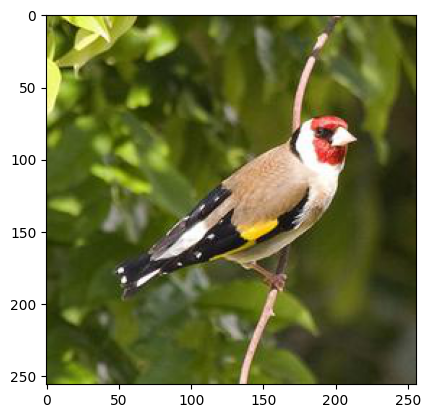

In [74]:
plt.imshow(train_imgs[0].transpose(1, 2, 0) / 255)

## Save train images

In [77]:
from tqdm import tqdm

IMG_SAVEDIR = "./data/bird256/train_palette/images/"
PLT_SAVEDIR = "./data/bird256/train_palette/palettes/"

# save images into the savedir
for idx, img in tqdm(enumerate(train_imgs)):
    # save PNG file of the image
    plt.imsave(os.path.join(IMG_SAVEDIR, f"{idx}.png"), img.transpose(1, 2, 0) / 255)

10600it [04:41, 37.60it/s]


In [78]:
del train_imgs

In [82]:
for idx, pal in tqdm(enumerate(train_pals)):
    # save numpy array of the palette
    np.save(os.path.join(PLT_SAVEDIR, f"{idx}.npy"), pal)

10600it [00:01, 8567.33it/s]


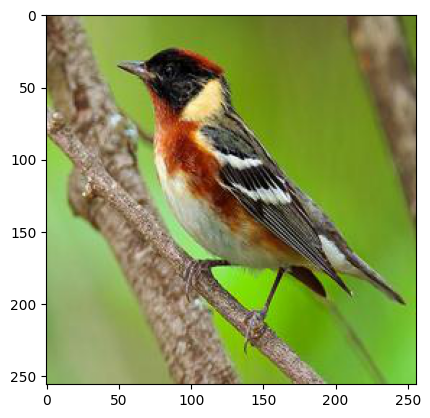

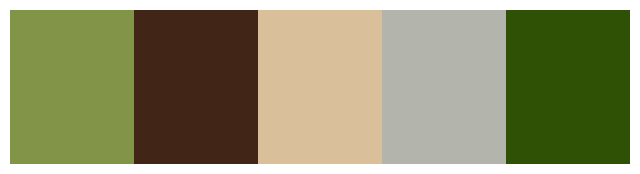

In [96]:
# test if the images and palettes are saved correctly
SAMPLE_IDX = np.random.randint(len(train_pals))
plt.imshow(plt.imread(os.path.join(IMG_SAVEDIR, f"{SAMPLE_IDX}.png")))
pal0 = np.load(os.path.join(PLT_SAVEDIR, f"{SAMPLE_IDX}.npy")).reshape(5, 3)
visualize_palette(pal0)

### Save test images

In [97]:
TEST_IMG_SAVEDIR = "./data/bird256/test_palette/images/"
TEST_PLT_SAVEDIR = "./data/bird256/test_palette/palettes/"

os.makedirs(TEST_IMG_SAVEDIR, exist_ok=True)
os.makedirs(TEST_PLT_SAVEDIR, exist_ok=True)

In [2]:
data_path_imgs = "data/bird256/test_palette/test_images_origin.txt"
data_path_palettes = "data/bird256/test_palette/test_palette_origin.txt"

with open(data_path_imgs, 'rb') as f:
    test_imgs = pkl.load(f)

with open(data_path_palettes, 'rb') as f:
    test_pals = pkl.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/bird256/test_palette/test_images_origin.txt'

In [101]:
for idx, img in tqdm(enumerate(test_imgs)):
    # save PNG file of the image
    plt.imsave(os.path.join(TEST_IMG_SAVEDIR, f"{idx}.png"), img.transpose(1, 2, 0) / 255)

1100it [00:25, 43.07it/s]


In [102]:
for idx, pal in tqdm(enumerate(test_pals)):
    # save numpy array of the palette
    np.save(os.path.join(TEST_PLT_SAVEDIR, f"{idx}.npy"), pal)

1100it [00:00, 8243.83it/s]


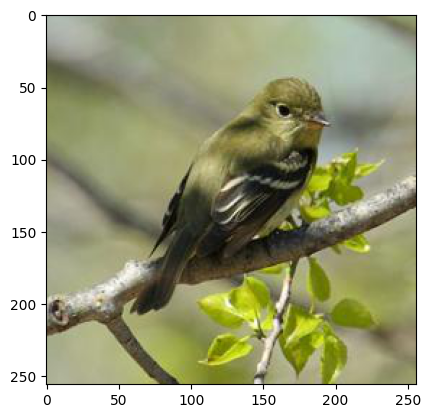

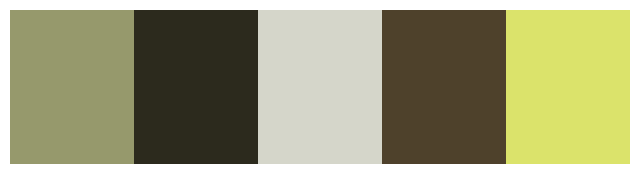

In [111]:
# Test if the images and palettes are saved correctly
SAMPLE_IDX = np.random.randint(len(test_pals))

plt.imshow(plt.imread(os.path.join(TEST_IMG_SAVEDIR, f"{SAMPLE_IDX}.png")))
pal0 = np.load(os.path.join(TEST_PLT_SAVEDIR, f"{SAMPLE_IDX}.npy")).reshape(5, 3)

visualize_palette(pal0)